Importing all the required libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import sklearn.metrics as metrics

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Uploading dataset

In [ ]:
app_train = pd.read_csv("application_train.csv")
app_test = pd.read_csv("application_test.csv")



Performing EDA on the dataset

In [ ]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,

In [ ]:
app_train['DAYS_BIRTH']

0         -9461
1        -16765
2        -19046
3        -19005
4        -19932
          ...  
307506    -9327
307507   -20775
307508   -14966
307509   -11961
307510   -16856
Name: DAYS_BIRTH, Length: 307511, dtype: int64

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Maximum value for this feature is 365243 days which is not possible. This seems like an outlier and must be removed.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


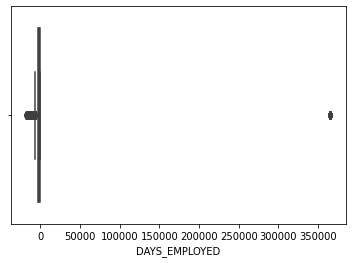

In [ ]:
sns.boxplot(app_train['DAYS_EMPLOYED'])

The numbers in DAYS_BIRTH and DAYS_EMPLOYED are negative integers. We will convert them into years by dividing them with -365.


In [ ]:
app_train['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)
app_train['YEARS_EMPLOYED']=app_train['DAYS_EMPLOYED']/-365

app_test['DAYS_EMPLOYED'].replace({365243:np.nan}, inplace=True)
app_test['YEARS_EMPLOYED']=app_test['DAYS_EMPLOYED']/-365

Text(0.5, 0, 'Years Employed')

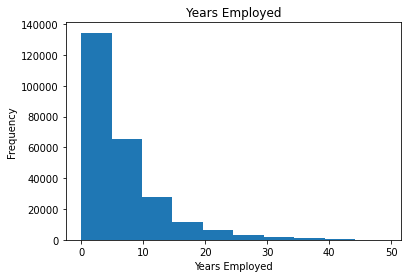

In [ ]:
app_train['YEARS_EMPLOYED'].plot.hist(title='Years Employed')
plt.xlabel("Years Employed")

In [ ]:
app_train['DAYS_BIRTH'].replace({365243:np.nan}, inplace=True)
app_train['YEARS_BIRTH']=app_train['DAYS_BIRTH']/-365

app_test['DAYS_BIRTH'].replace({365243:np.nan}, inplace=True)
app_test['YEARS_BIRTH']=app_test['DAYS_BIRTH']/-365


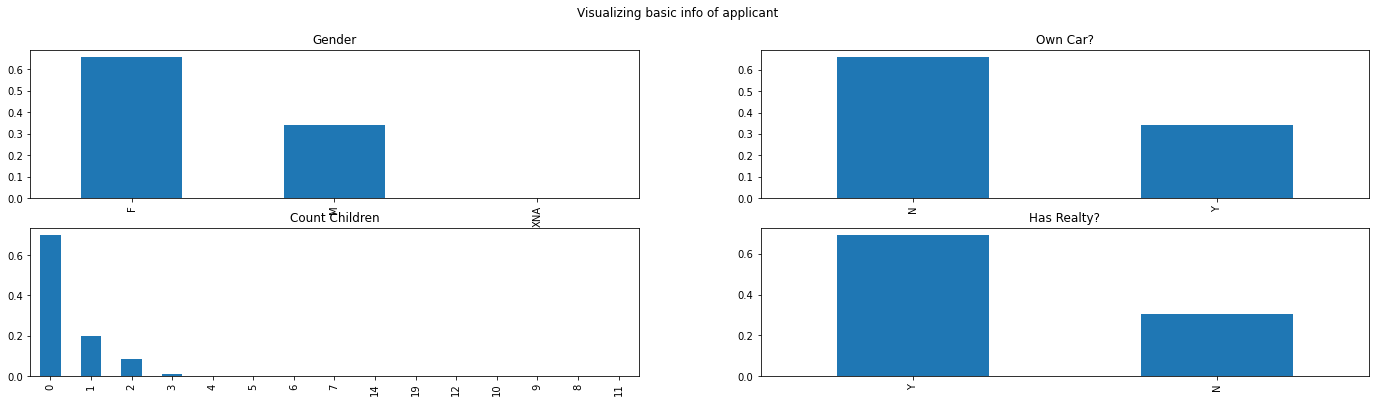

In [ ]:
image=plt.figure(1)
plt.suptitle("Visualizing basic info of applicant")

plt.subplot(221)
app_train['CODE_GENDER'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'Gender')

plt.subplot(222)
app_train['FLAG_OWN_CAR'].value_counts(normalize=True).plot.bar(title= 'Own Car?')

plt.subplot(223)
app_train['CNT_CHILDREN'].value_counts(normalize=True).plot.bar(title= 'Count Children')

plt.subplot(224)
app_train['FLAG_OWN_REALTY'].value_counts(normalize=True).plot.bar(figsize=(24,6), title= 'Has Realty?')


Looking at the plots we can see that most of the applicants owned a realty but not a car.
Also most of the applicants were female and had no children.

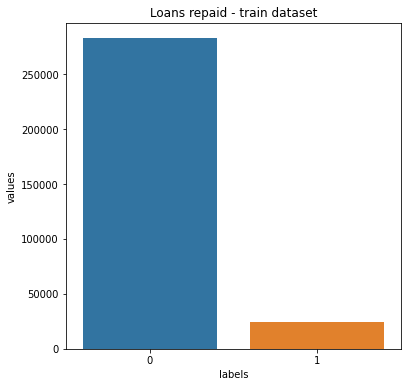

In [ ]:
b = app_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': b.index,
                   'values': b.values
                  })
image=plt.figure(figsize = (6,6))
plt.title('Loans repaid - train dataset')
sns.set_color_codes("colorblind")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

Looking at the plot we can say that most of loans were repaid.

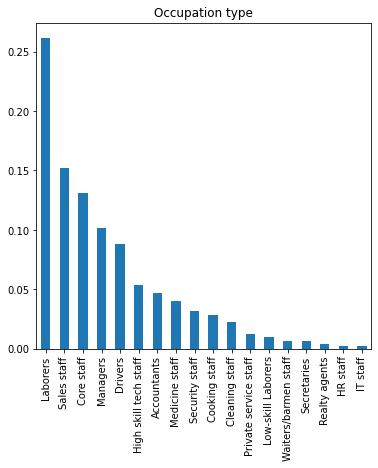

In [ ]:
image=plt.figure(figsize = (6,6))
app_train['OCCUPATION_TYPE'].value_counts(normalize=True).plot.bar(title= 'Occupation type')
plt.show()

Looking at the plot we can see that most of the loan applicant were labourers followed by the sales staff. Also IT staff takes the lowest amount of loan

Starting with selecting features for the model

In [ ]:
correlation = app_train.corr()['TARGET'].sort_values()
print(correlation.tail(10))
print(correlation.head(10))


REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
YEARS_BIRTH                  -0.078239
YEARS_EMPLOYED               -0.074958
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
Name: TARGET, dtype: float64


Will select the features that are most correlated with the class label 'TARGET', along with some features that provide basic information of the loan applicant.

In [ ]:
new_app_train = app_train[['SK_ID_CURR','TARGET','NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','AMT_INCOME_TOTAL','AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE','OCCUPATION_TYPE','ORGANIZATION_TYPE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','YEARS_EMPLOYED','FLOORSMAX_AVG','YEARS_BIRTH','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE']]
# new_app_train=app_train.copy()
new_app_train.head()

new_app_test = app_test[['SK_ID_CURR','NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','AMT_INCOME_TOTAL','AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE','OCCUPATION_TYPE','ORGANIZATION_TYPE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','YEARS_EMPLOYED','FLOORSMAX_AVG','YEARS_BIRTH','REGION_RATING_CLIENT_W_CITY','REGION_RATING_CLIENT','DAYS_LAST_PHONE_CHANGE']]
# new_app_test=app_test.copy()
new_app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,OCCUPATION_TYPE,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_EMPLOYED,FLOORSMAX_AVG,YEARS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE
0,100001,Cash loans,F,N,135000.0,20560.5,568800.0,450000.0,NaN,Kindergarten,0.752614,0.789654,0.159520,6.380822,0.125,52.715068,2,2,-1740.0
1,100005,Cash loans,M,N,99000.0,17370.0,222768.0,180000.0,Low-skill Laborers,Self-employed,0.564990,0.291656,0.432962,12.243836,NaN,49.490411,2,2,0.0
2,100013,Cash loans,M,Y,202500.0,69777.0,663264.0,630000.0,Drivers,Transport: type 3,NaN,0.699787,0.610991,12.213699,NaN,54.898630,2,2,-856.0
3,100028,Cash loans,F,N,315000.0,49018.5,1575000.0,1575000.0,Sales staff,Business Entity Type 3,0.525734,0.509677,0.612704,5.112329,0.375,38.290411,2,2,-1805.0
4,100038,Cash loans,M,Y,180000.0,32067.0,625500.0,625500.0,NaN,Business Entity Type 3,0.202145,0.425687,NaN,6.002740,NaN,35.726027,2,2,-821.0


We see that feature DAYS_LAST_PHONE_CHANGE is also represented in negative numbers. We will convert this feature too in years, the same way we did with DAYS_BIRTH and DAYS_EMPLOYED

In [ ]:
new_app_train['YEARS_LAST_PHONE_CHANGE']=new_app_train['DAYS_LAST_PHONE_CHANGE']/-365

new_app_test['YEARS_LAST_PHONE_CHANGE']=new_app_test['DAYS_LAST_PHONE_CHANGE']/-365

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
new_app_train = new_app_train.drop(columns=['DAYS_LAST_PHONE_CHANGE'])
new_app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,OCCUPATION_TYPE,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_EMPLOYED,FLOORSMAX_AVG,YEARS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,YEARS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,202500.0,24700.5,406597.5,351000.0,Laborers,Business Entity Type 3,0.083037,0.262949,0.139376,1.745205,0.0833,25.920548,2,2,3.106849
1,100003,0,Cash loans,F,N,270000.0,35698.5,1293502.5,1129500.0,Core staff,School,0.311267,0.622246,NaN,3.254795,0.2917,45.931507,1,1,2.268493
2,100004,0,Revolving loans,M,Y,67500.0,6750.0,135000.0,135000.0,Laborers,Government,NaN,0.555912,0.729567,0.616438,NaN,52.180822,2,2,2.232877
3,100006,0,Cash loans,F,N,135000.0,29686.5,312682.5,297000.0,Laborers,Business Entity Type 3,NaN,0.650442,NaN,8.326027,NaN,52.068493,2,2,1.690411
4,100007,0,Cash loans,M,N,121500.0,21865.5,513000.0,513000.0,Core staff,Religion,NaN,0.322738,NaN,8.323288,NaN,54.608219,2,2,3.030137


In [ ]:
new_app_test = new_app_test.drop(columns=['DAYS_LAST_PHONE_CHANGE'])
new_app_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,OCCUPATION_TYPE,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_EMPLOYED,FLOORSMAX_AVG,YEARS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,YEARS_LAST_PHONE_CHANGE
0,100001,Cash loans,F,N,135000.0,20560.5,568800.0,450000.0,NaN,Kindergarten,0.752614,0.789654,0.159520,6.380822,0.125,52.715068,2,2,4.767123
1,100005,Cash loans,M,N,99000.0,17370.0,222768.0,180000.0,Low-skill Laborers,Self-employed,0.564990,0.291656,0.432962,12.243836,NaN,49.490411,2,2,-0.000000
2,100013,Cash loans,M,Y,202500.0,69777.0,663264.0,630000.0,Drivers,Transport: type 3,NaN,0.699787,0.610991,12.213699,NaN,54.898630,2,2,2.345205
3,100028,Cash loans,F,N,315000.0,49018.5,1575000.0,1575000.0,Sales staff,Business Entity Type 3,0.525734,0.509677,0.612704,5.112329,0.375,38.290411,2,2,4.945205
4,100038,Cash loans,M,Y,180000.0,32067.0,625500.0,625500.0,NaN,Business Entity Type 3,0.202145,0.425687,NaN,6.002740,NaN,35.726027,2,2,2.249315


Since we are considering Occupation Type, I will drop the organization type feature.

In [ ]:
new_app_train = new_app_train.drop(columns=['ORGANIZATION_TYPE'])

new_app_test = new_app_test.drop(columns=['ORGANIZATION_TYPE'])

Factorizing the categorical features present in the dataset

In [ ]:
for bin_feature in ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','OCCUPATION_TYPE']:
  new_app_train[bin_feature],uniques=pd.factorize(new_app_train[bin_feature])

In [ ]:
for bin_feature in ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','OCCUPATION_TYPE']:
  new_app_test[bin_feature],uniques=pd.factorize(new_app_test[bin_feature])

In [ ]:
new_app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,OCCUPATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_EMPLOYED,FLOORSMAX_AVG,YEARS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,YEARS_LAST_PHONE_CHANGE
0,100002,1,0,0,0,202500.0,24700.5,406597.5,351000.0,0,0.083037,0.262949,0.139376,1.745205,0.0833,25.920548,2,2,3.106849
1,100003,0,0,1,0,270000.0,35698.5,1293502.5,1129500.0,1,0.311267,0.622246,NaN,3.254795,0.2917,45.931507,1,1,2.268493
2,100004,0,1,0,1,67500.0,6750.0,135000.0,135000.0,0,NaN,0.555912,0.729567,0.616438,NaN,52.180822,2,2,2.232877
3,100006,0,0,1,0,135000.0,29686.5,312682.5,297000.0,0,NaN,0.650442,NaN,8.326027,NaN,52.068493,2,2,1.690411
4,100007,0,0,0,0,121500.0,21865.5,513000.0,513000.0,1,NaN,0.322738,NaN,8.323288,NaN,54.608219,2,2,3.030137


Looking for NULL values in the dataset

In [ ]:
new_app_train.isnull().sum().sum()

443688

In [ ]:
def find_missing(data):
    ## Number of missing values
    missing_cnt = data.isnull().sum().values
    ## Total
    total = data.shape[0]
    ##Percentage of Missing values
    percentage = missing_cnt/total * 100
    missing_df = pd.DataFrame(data={'Total': total, 'Missing Count' : missing_cnt,'Percentage' : percentage}, 
                              index=data.columns.values)
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    return missing_df

In [ ]:
find_missing(new_app_train)

,Total,Missing Count,Percentage
EXT_SOURCE_1,307511,173378,56.381073
FLOORSMAX_AVG,307511,153020,49.760822
EXT_SOURCE_3,307511,60965,19.825307
YEARS_EMPLOYED,307511,55374,18.007161
EXT_SOURCE_2,307511,660,0.214626
AMT_GOODS_PRICE,307511,278,0.090403
AMT_ANNUITY,307511,12,0.003902
YEARS_LAST_PHONE_CHANGE,307511,1,0.000325


In [ ]:
find_missing(new_app_test)

,Total,Missing Count,Percentage
FLOORSMAX_AVG,48744,23321,47.843837
EXT_SOURCE_1,48744,20532,42.122107
YEARS_EMPLOYED,48744,9274,19.025931
EXT_SOURCE_3,48744,8668,17.782701
AMT_ANNUITY,48744,24,0.049237
EXT_SOURCE_2,48744,8,0.016412


Replacing missing values with mean of their respective column 

In [ ]:
new_app_train['EXT_SOURCE_1'] = new_app_train['EXT_SOURCE_1'].fillna(new_app_train['EXT_SOURCE_1'].mean())
new_app_train['EXT_SOURCE_2'] = new_app_train['EXT_SOURCE_2'].fillna(new_app_train['EXT_SOURCE_2'].mean())
new_app_train['EXT_SOURCE_3'] = new_app_train['EXT_SOURCE_3'].fillna(new_app_train['EXT_SOURCE_3'].mean())
new_app_train['FLOORSMAX_AVG'] = new_app_train['FLOORSMAX_AVG'].fillna(new_app_train['FLOORSMAX_AVG'].mean())
new_app_train['AMT_GOODS_PRICE'] = new_app_train['AMT_GOODS_PRICE'].fillna(new_app_train['AMT_GOODS_PRICE'].mean())
new_app_train['AMT_ANNUITY'] = new_app_train['AMT_ANNUITY'].fillna(new_app_train['AMT_ANNUITY'].mean())
new_app_train['YEARS_LAST_PHONE_CHANGE'] = new_app_train['YEARS_LAST_PHONE_CHANGE'].fillna(new_app_train['YEARS_LAST_PHONE_CHANGE'].mean())
new_app_train['YEARS_EMPLOYED'] = new_app_train['YEARS_EMPLOYED'].fillna(new_app_train['AMT_ANNUITY'].mean())

In [ ]:
new_app_test['EXT_SOURCE_1'] = new_app_test['EXT_SOURCE_1'].fillna(new_app_test['EXT_SOURCE_1'].mean())
new_app_test['EXT_SOURCE_2'] = new_app_test['EXT_SOURCE_2'].fillna(new_app_test['EXT_SOURCE_2'].mean())
new_app_test['EXT_SOURCE_3'] = new_app_test['EXT_SOURCE_3'].fillna(new_app_test['EXT_SOURCE_3'].mean())
new_app_test['FLOORSMAX_AVG'] = new_app_test['FLOORSMAX_AVG'].fillna(new_app_test['FLOORSMAX_AVG'].mean())
new_app_test['AMT_ANNUITY'] = new_app_test['AMT_ANNUITY'].fillna(new_app_test['AMT_ANNUITY'].mean())
new_app_test['YEARS_EMPLOYED'] = new_app_test['YEARS_EMPLOYED'].fillna(new_app_test['AMT_ANNUITY'].mean())

In [ ]:
new_app_train.isnull().sum().sum()
# new_app_train.head()

0

In [ ]:
new_app_test.isnull().sum().sum()

0

Mapping correlation heatmap of the features

Text(0.5, 1.0, 'Correlation heatmap')

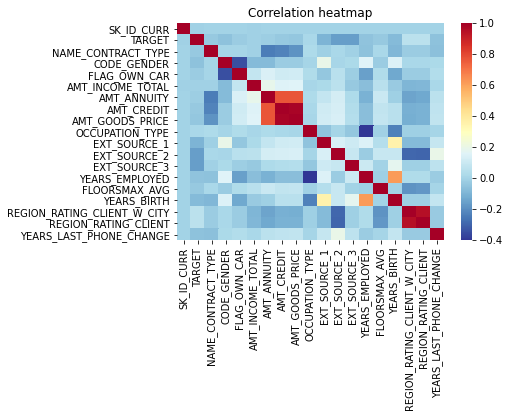

In [ ]:
train_corr = new_app_train.corr()
sns.heatmap(train_corr, cmap=plt.cm.RdYlBu_r)
plt.title('Correlation heatmap')

Now we will start applying model on the dataset

Standardizing the dataset

In [ ]:
new_app_trainset= new_app_train.drop(columns=['TARGET'])
new_app_train_label = new_app_train['TARGET']


In [ ]:
x=StandardScaler().fit_transform(new_app_trainset)
new_app_trainset_sub =  pd.DataFrame(x, columns=list(new_app_trainset.columns))

x_test = StandardScaler().fit_transform(new_app_test)
new_app_test_sub = pd.DataFrame(x_test,columns=list(new_app_test.columns) )

y_true = new_app_train_label

Before balancing the class label.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(new_app_trainset_sub, y_true, random_state=0, test_size=0.3)

In [ ]:
#Model 1 Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
print(classification_report(y_test,predictions))
dt_accuracy = metrics.accuracy_score(y_test, predictions)
print("Decision tree accuracy before sampling: ",str(dt_accuracy))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     84914
           1       0.14      0.17      0.15      7340

    accuracy                           0.85     92254
   macro avg       0.53      0.54      0.54     92254
weighted avg       0.86      0.85      0.86     92254

Decision tree accuracy before sampling:  0.8533613718646346


In [ ]:
# Model 2 Random Forest Classifier
rf = RandomForestClassifier(random_state=27)
rf.fit(X_train,y_train)
rf_predict = rf.predict(X_test)
print(classification_report(y_test, rf_predict))
rf_accuracy=metrics.accuracy_score(y_test, rf_predict)
print("Random Forest accuracy before sampling: "+str(rf_accuracy))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84914
           1       0.49      0.01      0.02      7340

    accuracy                           0.92     92254
   macro avg       0.71      0.50      0.49     92254
weighted avg       0.89      0.92      0.88     92254

Random Forest accuracy before sampling: 0.9204045353047022


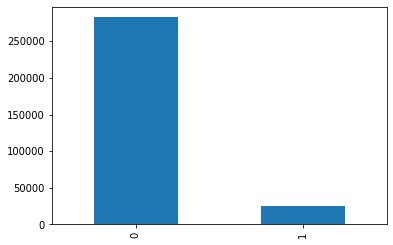

In [ ]:
pd.value_counts(y_true).plot.bar()

Looking at the plot we can see that the data is highly imbalanced. 


In [ ]:
print(y_true.value_counts())

0    282686
1     24825
Name: TARGET, dtype: int64


Performing sampling on the dataset to balance data using SMOTE function
Train:Test = 70:30

In [ ]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(new_app_trainset_sub, y_true, random_state=0, test_size=0.3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


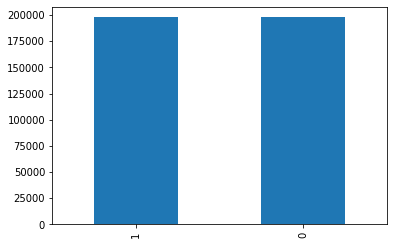

In [ ]:
sm1 = SMOTE(random_state=27)
X_train_sm1, y_train_sm1 = sm1.fit_sample(X_train1, y_train1)
pd.value_counts(y_train_sm1).plot.bar()


In [ ]:
# Decision Tree 
dtree1 = DecisionTreeClassifier()
dtree1.fit(X_train_sm1,y_train_sm1)
predictions_sm1 = dtree1.predict(X_test1)
print(classification_report(y_test1,predictions_sm1))
dt_accuracy_sm1 = metrics.accuracy_score(y_test1, predictions_sm1)
print("Decision tree accuracy after sampling with split 70:30: ",str(dt_accuracy_sm1))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88     84914
           1       0.12      0.26      0.16      7340

    accuracy                           0.79     92254
   macro avg       0.52      0.55      0.52     92254
weighted avg       0.86      0.79      0.82     92254

Decision tree accuracy after sampling with split 70:30:  0.7921282546014266


In [ ]:
# Random Forest
rf1 = RandomForestClassifier(random_state=27)
rf1.fit(X_train_sm1, y_train_sm1)
rf_pred1 = rf1.predict(X_test1)
print(confusion_matrix(y_test1,rf_pred1))
print(classification_report(y_test1,rf_pred1))

[[81099  3815]
 [ 6231  1109]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     84914
           1       0.23      0.15      0.18      7340

    accuracy                           0.89     92254
   macro avg       0.58      0.55      0.56     92254
weighted avg       0.87      0.89      0.88     92254



Random Forest after sampling with split 70:30:
Accuracy: 0.8911049927374423
Precision: 0.2252233956133225
Recall: 0.1510899182561308
F1 Score: 0.18085453359425963
roc-auc score: 0.6969565440757852


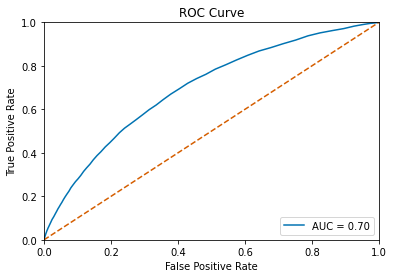

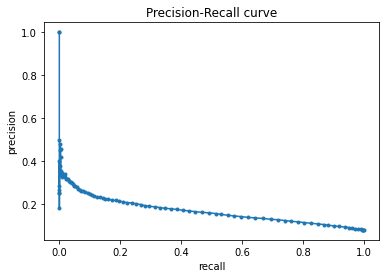

In [ ]:
print("Random Forest after sampling with split 70:30:")
rf_accuracy_sm1=metrics.accuracy_score(y_test1, rf_pred1)
matrix1= confusion_matrix(y_test1, rf_pred1)
tp1 = matrix1[1,1]
fp1 = matrix1[0,1]
tn1 = matrix1[0,0]
fn1 = matrix1[1,0]
prec1 = (tp1)/(tp1+fp1)
recall1 = (tp1)/(tp1+fn1)
f1_1 = f1_score(y_test1,rf_pred1) 
print("Accuracy: "+str(rf_accuracy_sm1))
print("Precision: "+str(prec1))
print("Recall: "+str(recall1))
print("F1 Score: "+str(f1_1))

probs1 = rf1.predict_proba(X_test1)
preds1 = probs1[:,1]
fpr1, tpr1, threshold = metrics.roc_curve(y_test1, preds1)
roc_auc1 = metrics.auc(fpr1, tpr1)
print("roc-auc score: "+str(roc_auc1))
plt.plot(fpr1, tpr1, 'b', label = 'AUC = %0.2f' % roc_auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

precision1, recall1, thresholds = precision_recall_curve(y_test1, preds1)
plt.title("Precision-Recall curve")
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot(recall1,precision1,marker='.')


Applying PCA

In [ ]:
pca1=PCA()
principal_components1 = pca1.fit_transform(new_app_trainset_sub)
pca1.explained_variance_ratio_.cumsum()

pca2=PCA()
principal_components2 = pca2.fit_transform(new_app_test_sub)
pca2.explained_variance_ratio_.cumsum()

array([0.18696918, 0.31534698, 0.42410692, 0.49639669, 0.56205074,
       0.61837752, 0.673939  , 0.72643153, 0.77770057, 0.825467  ,
       0.86400431, 0.90131249, 0.93469103, 0.96676418, 0.98195621,
       0.99617914, 0.99935142, 1.        ])

In [ ]:
pca1=PCA(n_components=18)
principal_components1 = pca1.fit_transform(new_app_trainset_sub)
new_app_trainset_trans = pd.DataFrame(data=principal_components1, columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10','pca11','pca12','pca13','pca14','pca15','pca16','pca17','pca18'])

pca2=PCA(n_components=18)
principal_components2 = pca2.fit_transform(new_app_test_sub)
new_app_test_trans = pd.DataFrame(data=principal_components2,columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7','pca8','pca9','pca10','pca11','pca12','pca13','pca14','pca15','pca16','pca17','pca18'])



In [ ]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(new_app_trainset_trans, y_true, random_state=6, test_size=0.3)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


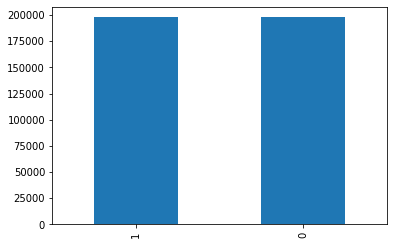

In [ ]:
sm_PCA = SMOTE(random_state=27)
X_train_sm_PCA, y_train_sm_PCA = sm1.fit_sample(X_train_PCA, y_train_PCA)
pd.value_counts(y_train_sm_PCA).plot.bar()

In [ ]:
#decision tree
dtree_PCA = DecisionTreeClassifier()
dtree_PCA.fit(X_train_sm_PCA,y_train_sm_PCA)
predictions_PCA = dtree_PCA.predict(X_test_PCA)
print(classification_report(y_test_PCA,predictions_PCA))
dt_accuracy_sm_PCA = metrics.accuracy_score(y_test_PCA, predictions_PCA)
print("Decision tree accuracy after sampling and PCA: ",str(dt_accuracy_sm_PCA))

              precision    recall  f1-score   support

           0       0.93      0.79      0.86     84888
           1       0.12      0.34      0.18      7366

    accuracy                           0.76     92254
   macro avg       0.53      0.56      0.52     92254
weighted avg       0.87      0.76      0.80     92254

Decision tree accuracy after sampling and PCA:  0.7558263056344441


In [ ]:
#random forest
rf_PCA = RandomForestClassifier(random_state=27)
rf_PCA.fit(X_train_sm_PCA, y_train_sm_PCA)
rf_pred_PCA = rf_PCA.predict(X_test_PCA)
print(confusion_matrix(y_test_PCA,rf_pred_PCA))
print(classification_report(y_test_PCA,rf_pred_PCA))
rf_accuracy_sm_PCA=metrics.accuracy_score(y_test_PCA, rf_pred_PCA)
print("Random Forest accuracy after sampling and PCA: "+str(rf_accuracy_sm_PCA))

[[77951  6937]
 [ 5479  1887]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     84888
           1       0.21      0.26      0.23      7366

    accuracy                           0.87     92254
   macro avg       0.57      0.59      0.58     92254
weighted avg       0.88      0.87      0.87     92254

Random Forest accuracy after sampling and PCA: 0.8654150497539402


Train:Test=80:20

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_app_trainset_sub, y_true, random_state=27, test_size=0.2)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


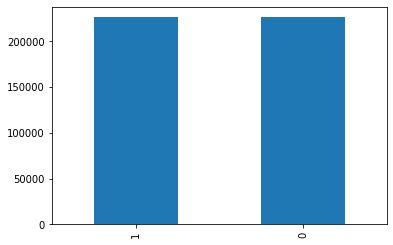

In [ ]:
sm2 = SMOTE(random_state=27)
X_train_sm2, y_train_sm2 = sm2.fit_sample(X_train2, y_train2)
pd.value_counts(y_train_sm2).plot.bar()

In [ ]:
#decision tree
dtree2 = DecisionTreeClassifier()
dtree2.fit(X_train_sm2,y_train_sm2)
predictions2 = dtree2.predict(X_test2)
print(classification_report(y_test2,predictions2))
dt_accuracy_sm2 = metrics.accuracy_score(y_test2, predictions2)
print("Decision tree accuracy after sampling with split 80:20 : ",str(dt_accuracy_sm2))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88     56460
           1       0.12      0.25      0.16      5043

    accuracy                           0.79     61503
   macro avg       0.52      0.54      0.52     61503
weighted avg       0.86      0.79      0.82     61503

Decision tree accuracy after sampling with split 80:20 :  0.792530445669317


In [ ]:
#random forest
rf2 = RandomForestClassifier(random_state=27)
rf2.fit(X_train_sm2, y_train_sm2)
rf_pred2 = rf2.predict(X_test2)
print(confusion_matrix(y_test2,rf_pred2))
print(classification_report(y_test2,rf_pred2))

[[53867  2593]
 [ 4272   771]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     56460
           1       0.23      0.15      0.18      5043

    accuracy                           0.89     61503
   macro avg       0.58      0.55      0.56     61503
weighted avg       0.87      0.89      0.88     61503



Random Forest after sampling with split 80:20:
Accuracy: 0.8883794286457571
Precision: 0.22919143876337694
Recall: 0.15288518738845924
F1 Score: 0.1834185797549661
roc-auc score: 0.6974973692415964


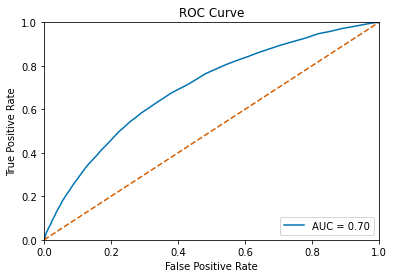

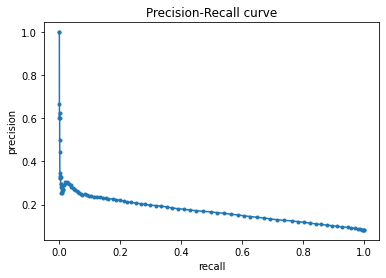

In [ ]:
print("Random Forest after sampling with split 80:20:")
rf_accuracy_sm2=metrics.accuracy_score(y_test2, rf_pred2)
matrix2= confusion_matrix(y_test2, rf_pred2)
tp2 = matrix2[1,1]
fp2 = matrix2[0,1]
tn2 = matrix2[0,0]
fn2 = matrix2[1,0]
prec2 = (tp2)/(tp2+fp2)
recall2 = (tp2)/(tp2+fn2)
f1_2 = f1_score(y_test2,rf_pred2) 
print("Accuracy: "+str(rf_accuracy_sm2))
print("Precision: "+str(prec2))
print("Recall: "+str(recall2))
print("F1 Score: "+str(f1_2))

probs2 = rf2.predict_proba(X_test2)
preds2 = probs2[:,1]
fpr2, tpr2, threshold = metrics.roc_curve(y_test2, preds2)
roc_auc2 = metrics.auc(fpr2, tpr2)
print("roc-auc score: "+str(roc_auc2))
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

precision2, recall2, thresholds = precision_recall_curve(y_test2, preds2)
plt.title("Precision-Recall curve")
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot(recall2,precision2,marker='.')


Train:Test = 60:40

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(new_app_trainset_sub,y_true, random_state=6, test_size=0.4)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


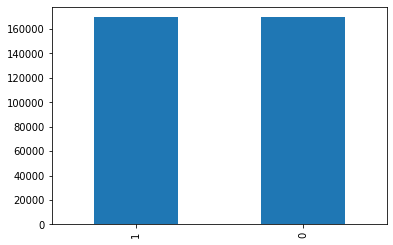

In [ ]:
sm3 = SMOTE(random_state=27)
X_train_sm3, y_train_sm3 = sm3.fit_sample(X_train3, y_train3)
pd.value_counts(y_train_sm3).plot.bar()

In [ ]:
#decision tree
dtree3 = DecisionTreeClassifier()
dtree3.fit(X_train_sm3,y_train_sm3)
predictions3 = dtree3.predict(X_test3)
print(classification_report(y_test3,predictions3))
dt_accuracy_sm3 = metrics.accuracy_score(y_test3, predictions3)
print("Decision tree accuracy after sampling with split 60:40 : ",str(dt_accuracy_sm3))


              precision    recall  f1-score   support

           0       0.93      0.84      0.88    113116
           1       0.12      0.25      0.16      9889

    accuracy                           0.79    123005
   macro avg       0.52      0.54      0.52    123005
weighted avg       0.86      0.79      0.82    123005

Decision tree accuracy after sampling with split 60:40 :  0.7877809845128246


In [ ]:
#random forest
rf3 = RandomForestClassifier(random_state=27)
rf3.fit(X_train_sm3, y_train_sm3)
rf_pred3 = rf3.predict(X_test3)
print(confusion_matrix(y_test3,rf_pred3))
print(classification_report(y_test3,rf_pred3))


[[108027   5089]
 [  8467   1422]]
              precision    recall  f1-score   support

           0       0.93      0.96      0.94    113116
           1       0.22      0.14      0.17      9889

    accuracy                           0.89    123005
   macro avg       0.57      0.55      0.56    123005
weighted avg       0.87      0.89      0.88    123005



Random Forest after sampling with split 60:40:
Accuracy: 0.8897930978415511
Precision: 0.21839963139302718
Recall: 0.1437961371220548
F1 Score: 0.17341463414634148
roc-auc score: 0.6968900161144052


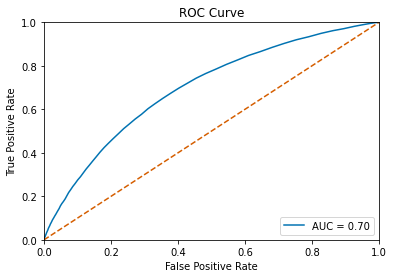

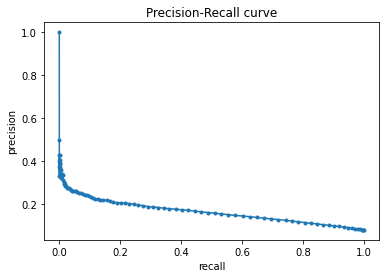

In [60]:
print("Random Forest after sampling with split 60:40:")
rf_accuracy_sm3=metrics.accuracy_score(y_test3, rf_pred3)
matrix3= confusion_matrix(y_test3, rf_pred3)
tp3 = matrix3[1,1]
fp3 = matrix3[0,1]
tn3 = matrix3[0,0]
fn3 = matrix3[1,0]
prec3 = (tp3)/(tp3+fp3)
recall3 = (tp3)/(tp3+fn3)
f1_3 = f1_score(y_test3,rf_pred3) 
print("Accuracy: "+str(rf_accuracy_sm3))
print("Precision: "+str(prec3))
print("Recall: "+str(recall3))
print("F1 Score: "+str(f1_3))

probs3 = rf3.predict_proba(X_test3)
preds3 = probs3[:,1]
fpr3, tpr3, threshold = metrics.roc_curve(y_test3, preds3)
roc_auc3 = metrics.auc(fpr3, tpr3)
print("roc-auc score: "+str(roc_auc3))
plt.plot(fpr3, tpr3, 'b', label = 'AUC = %0.2f' % roc_auc3)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("ROC Curve")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

precision3, recall3, thresholds = precision_recall_curve(y_test3, preds3)
plt.title("Precision-Recall curve")
plt.xlabel('recall')
plt.ylabel('precision')
plt.plot(recall3,precision3,marker='.')


Looing at Feature importance in the random forest:


In [63]:
lst=rf1.feature_importances_
d={'columns':new_app_trainset.columns,'features':lst}
dff=pd.DataFrame(d)
dff=dff.sort_values(by=['features'],ascending=False)
print(dff)

                        columns  features
11                 EXT_SOURCE_3  0.110404
13                FLOORSMAX_AVG  0.108461
10                 EXT_SOURCE_2  0.100881
8               OCCUPATION_TYPE  0.086571
4              AMT_INCOME_TOTAL  0.081473
7               AMT_GOODS_PRICE  0.065388
17      YEARS_LAST_PHONE_CHANGE  0.064848
14                  YEARS_BIRTH  0.059568
6                    AMT_CREDIT  0.056908
5                   AMT_ANNUITY  0.056487
0                    SK_ID_CURR  0.055712
12               YEARS_EMPLOYED  0.055552
9                  EXT_SOURCE_1  0.055222
2                   CODE_GENDER  0.010485
3                  FLAG_OWN_CAR  0.009827
16         REGION_RATING_CLIENT  0.008993
15  REGION_RATING_CLIENT_W_CITY  0.008892
1            NAME_CONTRACT_TYPE  0.004329


In [64]:
impFeatures=dff.iloc[0:10,0:1]
impFeatures=impFeatures['columns'].values.tolist()
print(impFeatures)


['EXT_SOURCE_3', 'FLOORSMAX_AVG', 'EXT_SOURCE_2', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL', 'AMT_GOODS_PRICE', 'YEARS_LAST_PHONE_CHANGE', 'YEARS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY']
